In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import os

ModuleNotFoundError: No module named 'pandas'

# Data Generation

In [ ]:
def relu(a):
    return np.maximum(a, 0.0)

# Data Generation
def data(N,d):
    np.random.seed(0)
    
    # Case 1: Random - Uniform (-1,1)
    X1 = np.random.uniform(-1, 1, size=(N, d)).astype(np.float32)
    y1 = np.random.uniform(-1, 1, size=(N, 1)).astype(np.float32)

    # Case 2: Functional relationship - Ground-Truth ReLU network
    X2 = np.random.uniform(-1, 1, size=(N, d)).astype(np.float32)
    K_true = math.ceil(N / 2)
    W_true = np.random.randn(d, K_true) * 0.5
    b_true = np.random.randn(K_true) * 0.1
    v_true  = np.random.randn(K_true) * 0.5
    hidden_layer = relu(X2 @ W_true + b_true)
    y = hidden_layer @ v_true
    noise = 0.05 * np.random.randn(N)
    y2 = y + noise
    y2=y2.astype(np.float32)
    
    # Case 3:
    r = math.ceil(d / 2)
    Z = np.random.randn(N, r)
    A = np.random.randn(d, r)
    X3 = Z @ A.T
    X3=X3.astype(np.float32)
    w_true = np.zeros(d)
    w_true[:3] = [1.0, -1.5, 0.7]
    y3= X3 @ w_true + 0.05 * np.random.randn(N)
    y3=y3.astype(np.float32)

    return X1, X2, X3, y1, y2, y3

# Continuous Opt with Regularizer

In [ ]:
p1 = 0.4
p2 = 0.7
p3 = 1
gamma = 0.01      # learning rate
num_epochs = 100000
lambda_reg = 0.005  # regularization weight
eps = 1e-6  # threshold for counting nonzeros
incl_bias_sparsity = True # whether or not to include and penalize biases in the sparsity measure
save_figs = True # optional: save plots as .png

torch.manual_seed(20)

# for saving figures
if save_figs:
    fig_dir = 'figs/high_d/'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

In [ ]:
N, d = 7, 5
K = N
X1, X2, X3, y1, y2, y3 = data(N,d)

In [ ]:
# Define single-hidden-layer ReLU network
class ReLURegNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # hidden layer weights w_k and biases b_k
        self.hidden = nn.Linear(input_dim, hidden_dim, bias=True)
        # output weights v_k (no bias)
        self.output = nn.Linear(hidden_dim, 1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = self.hidden(x)        # pre-activations [N, K]
        h = self.relu(z)          # activations [N, K]
        out = self.output(h)      # output [N, 1]
        return out, z

In [ ]:
# Instantiate models
model_none = ReLURegNet(d, K)
model_wd = copy.deepcopy(model_none)
model_p1 = copy.deepcopy(model_none)
model_p2 = copy.deepcopy(model_none)
model_p3 = copy.deepcopy(model_none)

# Optimizers
opt_none = optim.Adam(model_none.parameters(), lr=gamma)
opt_wd = optim.AdamW(model_wd.parameters(), lr=gamma, weight_decay=lambda_reg)
opt_p1 = optim.Adam(model_p1.parameters(), lr=gamma)
opt_p2 = optim.Adam(model_p2.parameters(), lr=gamma)
opt_p3 = optim.Adam(model_p3.parameters(), lr=gamma)

criterion = nn.MSELoss()

# History storage
epochs = []
metrics = {
    'none': {'mse': [], 'spars': [], 'act': []},
    'wd': {'mse': [], 'spars': [], 'act': []},
    'p1': {'mse': [], 'spars': [], 'act': [], 'lp': []},
    'p2': {'mse': [], 'spars': [], 'act': [], 'lp': []},
    'p3': {'mse': [], 'spars': [], 'act': [], 'lp': []},
}

# Utility: lp path norm
def lp_path_norm(model, p):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return (W*V).abs().pow(p).sum().item()

# Utility: count nonzeros (l0 path norm)
def count_nonzero(model):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return int((W * V).abs().gt(eps).sum().item())

# Utility: count active neurons
def count_active_neurons(model):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return int(((W*V).abs().ge(eps).any(dim=1)).sum().item())

In [ ]:
# convert numpy -> torch
x_train = torch.from_numpy(X1)
y_train = torch.from_numpy(y1)

# Training loop
for epoch in range(1, num_epochs+1):
    # No regularization
    opt_none.zero_grad()
    y_none, _ = model_none(x_train)
    loss_none = criterion(y_none, y_train)
    loss_none.backward(); opt_none.step()

    # AdamW
    opt_wd.zero_grad()
    y_wd, _ = model_wd(x_train)
    loss_wd = criterion(y_wd, y_train)
    loss_wd.backward(); opt_wd.step()
    
    p_models_opts = [(p1, model_p1, opt_p1), (p2, model_p2, opt_p2), (p3, model_p3, opt_p3)]
    
    for p, model, opt in p_models_opts:
        prev_V = model.output.weight.view(-1,1)
        if incl_bias_sparsity:
            prev_W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
        else:
            prev_W = model.hidden.weight

        # # copies (won't change the model's params)
        # W1 = model.hidden.weight.clone()
        # b1 = model.hidden.bias.clone()
        # W2 = model.output.weight.clone()
        
        # W1 = torch.where(W1.abs() <= eps, torch.zeros_like(W1), W1)
        # b1 = torch.where(b1.abs() <= eps, torch.zeros_like(b1), b1)
        # W2 = torch.where(W2.abs() <= eps, torch.zeros_like(W2), W2)
        
        # z = x_train @ W1.T + b1
        # h = torch.relu(z)
        # out = h @ W2.T
        # err_thresh = torch.sum((out - y_train) ** 2)
        
        opt.zero_grad()
        y_pred, _ = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward(); opt.step()

    
        if epoch > 5:  # reweighted l1 update
            prev_prod = (prev_V * prev_W)
            C = lambda_reg * gamma * p * prev_prod.abs().pow(p-1)
            new_V = model.output.weight.view(-1,1)
            if incl_bias_sparsity:
                new_W = torch.cat((model.hidden.weight, model.hidden.bias[:, None].data.clone()), dim=1)
            else:
                new_W = model.hidden.weight
            new_prod = new_V * new_W
            sign = new_prod.sign()
            mag = new_prod.abs()
            u = torch.where(mag <= C, torch.zeros_like(new_prod), new_prod - C*sign)
            u_norms = torch.linalg.vector_norm(u, dim=1, ord=2)
            mask = (u_norms >= eps) 
            den = torch.sqrt(u_norms).masked_fill(~mask, 1.0)
            u_div = (torch.abs(u) / den[:, None]).masked_fill(~mask[:, None], 0.0)

            model.output.weight.data = torch.sqrt(u_norms).reshape(model.output.weight.data.shape) * torch.sign(model.output.weight.data)
            if incl_bias_sparsity:
                model.hidden.weight.data = u_div[:, :-1].reshape(model.hidden.weight.data.shape) * torch.sign(model.hidden.weight.data)
                model.hidden.bias.data = u_div[:, -1].reshape(model.hidden.bias.data.shape) * torch.sign(model.hidden.bias.data)
            else:
                model.hidden.weight.data = u_div.reshape(model.hidden.weight.data.shape) * torch.sign(model.hidden.weight.data)
        
    # Record and print
    if epoch % 5000 == 0 or epoch == 1 or epoch == num_epochs:
        # print(loss.item())
        # print(err_thresh.item())
        epochs.append(epoch)
        for name, model in [('none', model_none), ('wd', model_wd), ('p1', model_p1), ('p2', model_p2), ('p3', model_p3)]:
            y_pred, _ = model(x_train)
            metrics[name]['mse'].append(criterion(y_pred, y_train).item())
            # metrics[name]['mse'].append(err_thresh.item())
            metrics[name]['spars'].append(count_nonzero(model))
            metrics[name]['act'].append(count_active_neurons(model))
            if name == 'p1':
                metrics[name]['lp'].append(lp_path_norm(model, p1))
            elif name == 'p2':
                metrics[name]['lp'].append(lp_path_norm(model, p2))
            elif name == 'p3':
                metrics[name]['lp'].append(lp_path_norm(model, p3))

        print(f"Epoch {epoch}:  "
              f"No reg (MSE={metrics['none']['mse'][-1]:.2e},spars={metrics['none']['spars'][-1]},act={metrics['none']['act'][-1]}) | "
              f"WD (MSE={metrics['wd']['mse'][-1]:.2e},spars={metrics['wd']['spars'][-1]},act={metrics['wd']['act'][-1]}) | "
              f"p={p1} (MSE={metrics['p1']['mse'][-1]:.2e},spars={metrics['p1']['spars'][-1]},act={metrics['p1']['act'][-1]}) | "
              f"p={p2} (MSE={metrics['p2']['mse'][-1]:.2e},spars={metrics['p2']['spars'][-1]},act={metrics['p2']['act'][-1]}) | "
              f"p={p3} (MSE={metrics['p3']['mse'][-1]:.2e},spars={metrics['p3']['spars'][-1]},act={metrics['p3']['act'][-1]}) | ")

Epoch 1:  No reg (MSE=1.58e-01,spars=42,act=7) | WD (MSE=1.58e-01,spars=42,act=7) | p=0.4 (MSE=1.58e-01,spars=42,act=7) | p=0.7 (MSE=1.58e-01,spars=42,act=7) | p=1 (MSE=1.58e-01,spars=42,act=7) | 
Epoch 5000:  No reg (MSE=1.76e-08,spars=42,act=7) | WD (MSE=3.40e-09,spars=42,act=7) | p=0.4 (MSE=5.03e-08,spars=13,act=4) | p=0.7 (MSE=1.20e-07,spars=13,act=4) | p=1 (MSE=5.26e-09,spars=27,act=5) | 
Epoch 10000:  No reg (MSE=4.71e-07,spars=42,act=7) | WD (MSE=3.46e-08,spars=42,act=7) | p=0.4 (MSE=1.89e-06,spars=12,act=4) | p=0.7 (MSE=1.06e-06,spars=13,act=4) | p=1 (MSE=9.87e-10,spars=25,act=5) | 
Epoch 15000:  No reg (MSE=4.44e-12,spars=42,act=7) | WD (MSE=2.61e-11,spars=42,act=7) | p=0.4 (MSE=1.57e-08,spars=12,act=4) | p=0.7 (MSE=1.18e-06,spars=12,act=4) | p=1 (MSE=1.61e-08,spars=28,act=5) | 
Epoch 20000:  No reg (MSE=3.30e-09,spars=42,act=7) | WD (MSE=3.11e-06,spars=42,act=7) | p=0.4 (MSE=5.37e-08,spars=10,act=4) | p=0.7 (MSE=1.91e-08,spars=11,act=4) | p=1 (MSE=5.67e-10,spars=15,act=4) | 


# Print the Results

In [ ]:
def l0_path_objective(model, eps=1e-6, incl_bias=True):
    """True objective: l0 norm of |v_k w_k| (and |v_k b_k| if incl_bias)."""
    with torch.no_grad():
        W = model.hidden.weight.detach()          # [K, d]
        b = model.hidden.bias.detach()            # [K]
        v = model.output.weight.detach().view(-1) # [K]

        prod_w = (W * v[:, None]).abs()           # [K, d]
        if incl_bias:
            prod_b = (b * v).abs().view(-1, 1)    # [K, 1]
            prod = torch.cat([prod_w, prod_b], dim=1)  # [K, d+1]
        else:
            prod = prod_w

        return int((prod > eps).sum().item())

def export_model_report(model, name, fig_dir, eps=1e-6, incl_bias=True, dpi=200):
    """
    Saves a PNG with W, b, v tables + summary stats.
    Also prints key numbers to console.
    """
    model.eval()
    with torch.no_grad():
        W = model.hidden.weight.detach().cpu().numpy()   # [K, d]
        b = model.hidden.bias.detach().cpu().numpy()     # [K]
        v = model.output.weight.detach().cpu().numpy().reshape(-1)  # [K]

    max_abs_W = float(np.max(np.abs(W)))
    max_abs_b = float(np.max(np.abs(b)))
    max_abs_v = float(np.max(np.abs(v)))

    l0_obj = l0_path_objective(model, eps=eps, incl_bias=incl_bias)

    # ----- build DataFrames (nice labels) -----
    K, d = W.shape
    df_W = pd.DataFrame(W, columns=[f"x{j+1}" for j in range(d)], index=[f"k{kk+1}" for kk in range(K)])
    df_b = pd.DataFrame(b.reshape(-1, 1), columns=["b"], index=df_W.index)
    df_v = pd.DataFrame(v.reshape(-1, 1), columns=["v"], index=df_W.index)

    # ----- plot as tables into one image -----
    fig = plt.figure(figsize=(12, 7))
    fig.suptitle(f"Model: {name}", fontsize=14)

    # Summary text
    summary = (
        f"max |W| = {max_abs_W:.3e}\n"
        f"max |b| = {max_abs_b:.3e}\n"
        f"max |v| = {max_abs_v:.3e}\n"
        f"true objective  || |v_k w_k| ||_0 = {l0_obj}   (eps={eps}, bias_included={incl_bias})"
    )
    ax0 = fig.add_subplot(2, 2, 1)
    ax0.axis("off")
    ax0.text(0.0, 1.0, summary, va="top", fontsize=11)

    def add_table(ax, df, title):
        ax.axis("off")
        ax.set_title(title, fontsize=12)
        tbl = ax.table(
            cellText=np.round(df.values, 6),
            rowLabels=df.index,
            colLabels=df.columns,
            loc="center",
            cellLoc="center"
        )
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(8)
        tbl.scale(1.2, 1.2)

    ax1 = fig.add_subplot(2, 2, 2)
    add_table(ax1, df_W, "Hidden weights W (K x d)")

    ax2 = fig.add_subplot(2, 2, 3)
    add_table(ax2, df_b, "Hidden bias b (K)")

    ax3 = fig.add_subplot(2, 2, 4)
    add_table(ax3, df_v, "Output weights v (K)")

    out_path = os.path.join(fig_dir, f"params_{name}.png")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # Console print (quick)
    print(f"[{name}] max|W|={max_abs_W:.3e}, max|b|={max_abs_b:.3e}, max|v|={max_abs_v:.3e}, l0_obj={l0_obj}")
    print(f"Saved: {out_path}")

    return out_path

def get_scaled_params(model, eps=1e-12):
    """
    Returns scaled (W, b, v) where v_k in {-1, 0, +1}
    and scaling is pushed into W, b.
    """
    with torch.no_grad():
        W = model.hidden.weight.detach().cpu()   # [K, d]
        b = model.hidden.bias.detach().cpu()     # [K]
        v = model.output.weight.detach().cpu().view(-1)  # [K]

        sign_v = torch.sign(v)
        abs_v = v.abs()

        zero_mask = abs_v <= eps

        W_scaled = W * abs_v[:, None]
        b_scaled = b * abs_v
        v_scaled = sign_v

        # handle v_k = 0 safely
        W_scaled[zero_mask, :] = 0.0
        b_scaled[zero_mask] = 0.0
        v_scaled[zero_mask] = 0.0

    return (
        W_scaled.numpy(),
        b_scaled.numpy(),
        v_scaled.numpy()
    )

def export_scaled_model_report(model, name, fig_dir, eps=1e-6, dpi=200):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    W, b, v = get_scaled_params(model)

    max_abs_W = float(np.max(np.abs(W)))
    max_abs_b = float(np.max(np.abs(b)))
    max_abs_v = float(np.max(np.abs(v)))  # will be 1 or 0

    K, d = W.shape
    df_W = pd.DataFrame(W, columns=[f"x{j+1}" for j in range(d)], index=[f"k{kk+1}" for kk in range(K)])
    df_b = pd.DataFrame(b.reshape(-1, 1), columns=["b"], index=df_W.index)
    df_v = pd.DataFrame(v.reshape(-1, 1), columns=["v ∈ {-1,0,1}"], index=df_W.index)

    fig = plt.figure(figsize=(12, 7))
    fig.suptitle(f"Scaled Parameters (Model: {name})", fontsize=14)

    summary = (
        "Scaling:  v_k → sign(v_k)\n"
        "          w_k → |v_k| w_k\n"
        "          b_k → |v_k| b_k\n\n"
        f"max |W| = {max_abs_W:.3e}\n"
        f"max |b| = {max_abs_b:.3e}\n"
        f"max |v| = {max_abs_v:.1f}"
    )

    ax0 = fig.add_subplot(2, 2, 1)
    ax0.axis("off")
    ax0.text(0.0, 1.0, summary, va="top", fontsize=11)

    def add_table(ax, df, title):
        ax.axis("off")
        ax.set_title(title, fontsize=12)
        tbl = ax.table(
            cellText=np.round(df.values, 6),
            rowLabels=df.index,
            colLabels=df.columns,
            loc="center",
            cellLoc="center"
        )
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(8)
        tbl.scale(1.2, 1.2)

    ax1 = fig.add_subplot(2, 2, 2)
    add_table(ax1, df_W, "Scaled hidden weights W̃")

    ax2 = fig.add_subplot(2, 2, 3)
    add_table(ax2, df_b, "Scaled bias b̃")

    ax3 = fig.add_subplot(2, 2, 4)
    add_table(ax3, df_v, "Scaled output weights ṽ")

    out_path = os.path.join(fig_dir, f"params_{name}_scaled.png")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print(f"[{name} | scaled] max|W|={max_abs_W:.3e}, max|b|={max_abs_b:.3e}, max|v|={max_abs_v:.1f}")
    print(f"Saved: {out_path}")

    return out_path

In [ ]:
def max_abs_params(model):
    with torch.no_grad():
        W = model.hidden.weight.detach()
        b = model.hidden.bias.detach()
        v = model.output.weight.detach().view(-1)

        return (
            float(W.abs().max().item()),
            float(b.abs().max().item()),
            float(v.abs().max().item()),
        )

# ---- select best model by true l0 objective ----
models = {
    "none": model_none,
    "wd": model_wd,
    f"p{p1}": model_p1,
    f"p{p2}": model_p2,
    f"p{p3}": model_p3,
}

l0_values = {
    name: l0_path_objective(model, eps=eps, incl_bias=incl_bias_sparsity)
    for name, model in models.items()
}

best_name = min(l0_values, key=l0_values.get)
best_model = models[best_name]
best_l0 = l0_values[best_name]

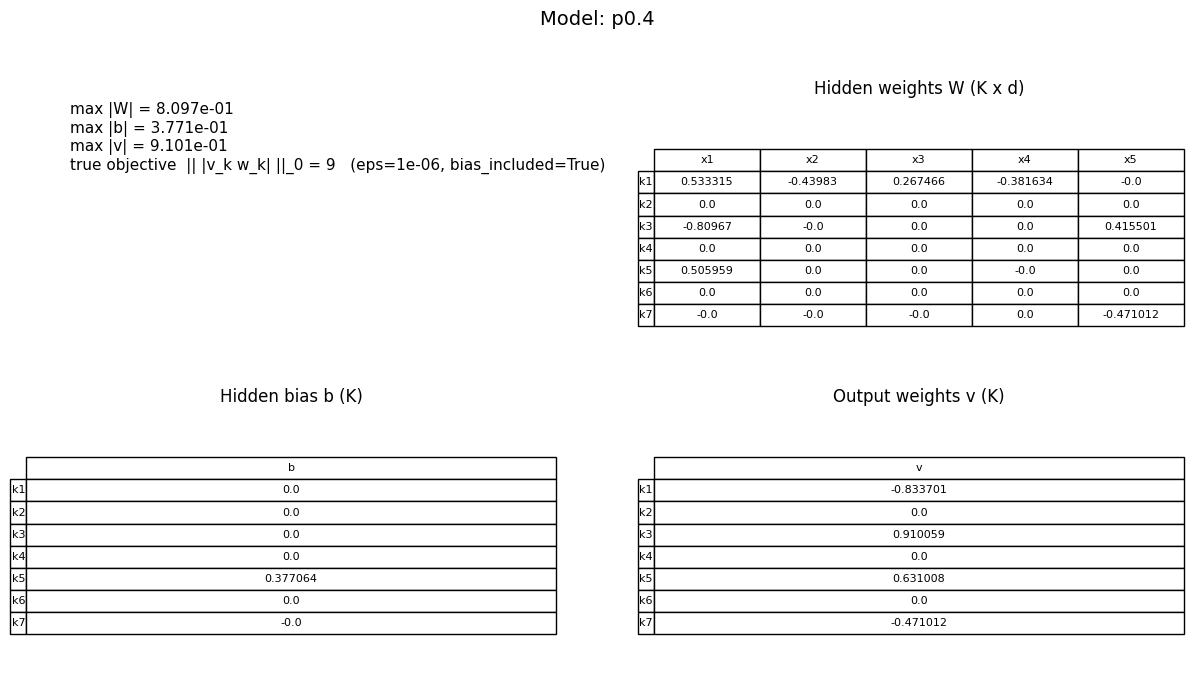

[p0.4] max|W|=8.097e-01, max|b|=3.771e-01, max|v|=9.101e-01, l0_obj=9
Saved: figs/high_d/params_p0.4.png

========== BEST MODEL (ORIGINAL) ==========
Selected model : p0.4
l0 objective   : 9
max |W|        : 8.097e-01
max |b|        : 3.771e-01
max |v|        : 9.101e-01
PNG saved to   : figs/high_d/params_p0.4.png



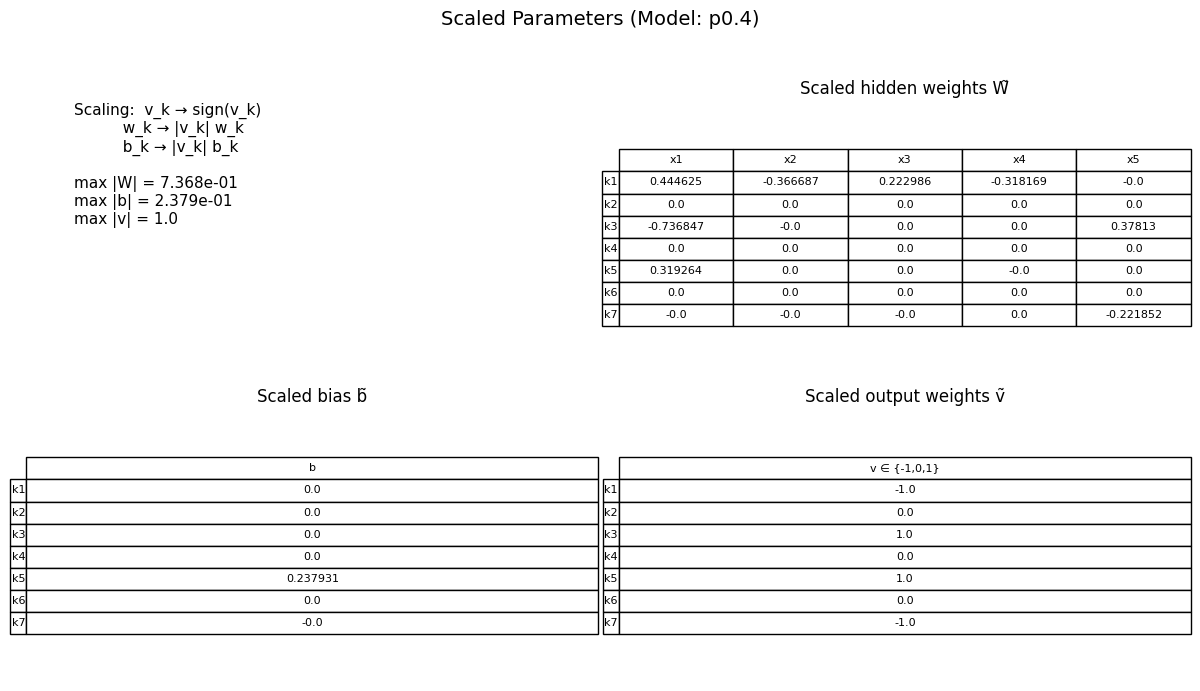

[p0.4 | scaled] max|W|=7.368e-01, max|b|=2.379e-01, max|v|=1.0
Saved: figs/high_d/params_p0.4_scaled.png

========== BEST MODEL (SCALED) ==========
Selected model : p0.4
Scaling rule   : v_k -> sign(v_k);  w,b -> |v_k|*(w,b);  handle v_k=0 safely
max |W̃|        : 7.368e-01
max |b̃|        : 2.379e-01
max |ṽ|        : 1.000e+00
PNG saved to   : figs/high_d/params_p0.4_scaled.png



In [ ]:
# ---- export ONLY the best model (original + scaled) ----

# 1) Original parameters image
orig_png_path = export_model_report(
    best_model,
    best_name,
    fig_dir,
    eps=eps,
    incl_bias=incl_bias_sparsity
)

# 2) Original max values
max_W, max_b, max_v = max_abs_params(best_model)

print("\n========== BEST MODEL (ORIGINAL) ==========")
print(f"Selected model : {best_name}")
print(f"l0 objective   : {best_l0}")
print(f"max |W|        : {max_W:.3e}")
print(f"max |b|        : {max_b:.3e}")
print(f"max |v|        : {max_v:.3e}")
print(f"PNG saved to   : {orig_png_path}")
print("==========================================\n")


# 3) Scaled parameters image (v_k -> sign(v_k), push |v_k| into W,b)
scaled_png_path = export_scaled_model_report(
    best_model,
    best_name,
    fig_dir,
    eps=eps
)

# 4) Scaled max values (compute from scaled params)
W_sc, b_sc, v_sc = get_scaled_params(best_model, eps=eps)
max_W_scaled = float(np.max(np.abs(W_sc)))
max_b_scaled = float(np.max(np.abs(b_sc)))
max_v_scaled = float(np.max(np.abs(v_sc)))  # should be 1 or 0

print("\n========== BEST MODEL (SCALED) ==========")
print(f"Selected model : {best_name}")
print(f"Scaling rule   : v_k -> sign(v_k);  w,b -> |v_k|*(w,b);  handle v_k=0 safely")
print(f"max |W̃|        : {max_W_scaled:.3e}")
print(f"max |b̃|        : {max_b_scaled:.3e}")
print(f"max |ṽ|        : {max_v_scaled:.3e}")
print(f"PNG saved to   : {scaled_png_path}")
print("========================================\n")

# MILP

In [ ]:
def solve_MILP(X, y, w_Bound, b_Bound, output_flag=1):
    
    # Input X has d dimension and N number of data
    N, d = X.shape
    # Width K = N
    K = N

    # GurobiPy
    m = gp.Model()

    # 1. Decision Variables
    # input weight
    W = m.addVars(d, K, lb=-w_Bound, ub=w_Bound, vtype=GRB.CONTINUOUS, name="W")
    # bias
    b = m.addVars(K, lb=-b_Bound, ub=b_Bound, vtype=GRB.CONTINUOUS, name="b")
    # output weight
    v_ = m.addVars(K, vtype=GRB.BINARY, name="v'")

    # ReLU: positive
    p = m.addVars(N, K, lb=0.0, vtype=GRB.CONTINUOUS, name="p")
    # ReLU: negative
    q = m.addVars(N, K, lb=0.0, vtype=GRB.CONTINUOUS, name="q")
    # Neuron Activation
    z = m.addVars(N, K, vtype=GRB.BINARY, name="z")
    # Number of Nonzero Weight
    t = m.addVars(d, K, vtype=GRB.BINARY, name="t")
    # Number of Nonzero Bias
    s = m.addVars(K, vtype=GRB.BINARY, name="s")
    # Auxiliary Variable (for McCormick)
    r = m.addVars(N, K, lb=0.0, vtype=GRB.CONTINUOUS, name="r")

    # 2. Objective Functions
    m.setObjective(
        gp.quicksum(t[i, k] for i in range(d) for k in range(K))
        +gp.quicksum(s[k] for k in range(K)),
        GRB.MINIMIZE
    )

    # 3. Constraints
    # Output of linear combination
    for n in range(N):
        for k in range(K):
            m.addConstr(
                gp.quicksum(W[i, k] * X[n, i] for i in range(d)) + b[k]
                == p[n, k] - q[n, k]
            )
    # Output of ReLU   
        # Big-M
    X_absmax = np.max(np.abs(X)) if X.size > 0 else 0.0
    M = d * w_Bound * X_absmax + b_Bound
    for n in range(N):
        for k in range(K):
            m.addConstr(p[n, k] <= M * z[n, k])
            m.addConstr(q[n, k] <= M * (1 - z[n, k]))
    # Data Fitting
    for n in range(N):
        m.addConstr(
            gp.quicksum(2 * r[n, k] - p[n, k] for k in range(K)) == y[n]
        )
    # McCormick
    for n in range(N):
        for k in range(K):
            m.addConstr(r[n, k] <= M * v_[k])
            m.addConstr(p[n, k] - M * (1 - v_[k]) <= r[n, k])
            m.addConstr(r[n, k] <= p[n, k])
    # Nonzero Weight/Bias Indicator
    for i in range(d):
        for k in range(K):
            m.addConstr(-w_Bound * t[i, k] <= W[i, k])
            m.addConstr(W[i, k] <= w_Bound * t[i, k])
    for k in range(K):
        m.addConstr(-b_Bound * s[k] <= b[k])
        m.addConstr(b[k] <= b_Bound * s[k])

    # Solve
    # m.setParam('OutputFlag', 0)
    m.optimize()

    # Print
    print(f"\nModel status: {m.status}")
    if m.status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        print(f"Objective value (sum t_ik): {m.ObjVal:.6f}")

    return W, b, v_, m.ObjVal

In [ ]:
epsilon=1
w_Bound=max_W_scaled+epsilon
b_Bound=max_b_scaled+epsilon
W, b, v_, ObjVal = solve_MILP(X1, y1, w_Bound, b_Bound)

Set parameter Username
Set parameter LicenseID to value 2649542
Academic license - for non-commercial use only - expires 2026-04-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 385 rows, 287 columns and 1197 nonzeros
Model fingerprint: 0x5684059a
Variable types: 189 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e-01, 1e+01]
Presolve time: 0.00s
Presolved: 385 rows, 287 columns, 1197 nonzeros
Variable types: 189 continuous, 98 integer (98 binary)
Found heuristic solution: objective 42.0000000
Found heuristic solution: objective 41.0000000

Root relaxation: objective 0.000000e+00, 91 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

/var/folders/7v/xh6pt85d41zcg0wdcn4d4wph0000gn/T/ipykernel_52075/4111321323.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.addConstr(


H 2741  1612                       7.0000000    1.00000  85.7%  14.8    0s
 91296 29534    5.00149   58    9    7.00000    2.28373  67.4%  24.8    5s
 199574 78149    2.97557   36   10    7.00000    2.76163  60.5%  25.9   10s
 307968 120702    3.44945   41    9    7.00000    3.00000  57.1%  26.6   15s
 417801 169042    4.16877   45   12    7.00000    3.00000  57.1%  26.7   20s
 530374 218290    4.00000   47    6    7.00000    3.00000  57.1%  26.8   25s
 642896 265899    5.58936   52    9    7.00000    3.00000  57.1%  26.7   30s
 754135 309469    5.11035   43    7    7.00000    3.05727  56.3%  26.4   35s
 865775 356008 infeasible   59         7.00000    3.14012  55.1%  26.3   40s
 979141 408591 infeasible   49         7.00000    3.19087  54.4%  26.3   45s
 1091521 452654    4.30468   45   12    7.00000    3.23307  53.8%  26.3   50s
 1204593 500400    5.00000   51    5    7.00000    3.27570  53.2%  26.3   55s
 1317022 546926     cutoff   42         7.00000    3.31499  52.6%  26.4   60s
 

# Verify the optimal solution

# MILP with Symmetry Handling Constraints